In [11]:
import pandas as pd 
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz
from sortedcontainers import SortedList
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

In [2]:
df=pd.read_csv('../data/edited_rating.csv')

In [3]:
N = df.User.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies
print(N,M)

6040 3706


# Split data 


In [4]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

# Model

In [6]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.Rating.mean() # global average 
epochs = 15

In [23]:
# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))

u_embedding = Embedding(N, K, embeddings_regularizer=l2(0))(u) # (N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(0))(m) # (N, 1, K)

u_bias = Embedding(N, 1, embeddings_regularizer=l2(0))(u) # (N, 1, 1)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(0))(m) # (N, 1, 1)

x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

In [35]:
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=SGD(learning_rate=0.01, momentum=0.9),
  metrics=['mse'],
) # loss & metrics are mse -> will not be the same if we use regularization 

In [36]:
history = model.fit(
  x=[df_train.User.values, df_train.movie_idx.values],
  y=df_train.Rating.values - mu,
  epochs=30,
  batch_size=128,
  validation_data=(
    [df_test.User.values, df_test.movie_idx.values],
    df_test.Rating.values - mu
  )
)

Epoch 1/30
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 6s 821us/step - loss: 0.7767 - mse: 0.7767 - val_loss: 0.7967 - val_mse: 0.7967
Epoch 2/30
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 5s 800us/step - loss: 0.7727 - mse: 0.7727 - val_loss: 0.7939 - val_mse: 0.7939
Epoch 3/30
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 5s 844us/step - loss: 0.7665 - mse: 0.7665 - val_loss: 0.7911 - val_mse: 0.7911
Epoch 4/30
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 5s 810us/step - loss: 0.7599 - mse: 0.7599 - val_loss: 0.7883 - val_mse: 0.7883
Epoch 5/30
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 5s 816us/step - loss: 0.7559 - mse: 0.7559 - val_loss: 0.7856 - val_mse: 0.7856
Epoch 6/30
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 6s 899us/step - loss: 0.7520 - mse: 0.7520 - val_loss: 0.7831 - val_mse: 0.7831
Epoch 7/30
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 6s 908us/step - loss: 0.7462 - mse: 0.7462 - val_loss: 0.7805 - val_mse: 0.7805
Epoch 8/30
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 6s 899us/step - loss: 0.7431 - mse: 0.7431 - val_loss: 0.7781 - val_mse: 0.7781
Epoch 9/30
6252/6252 ━━━

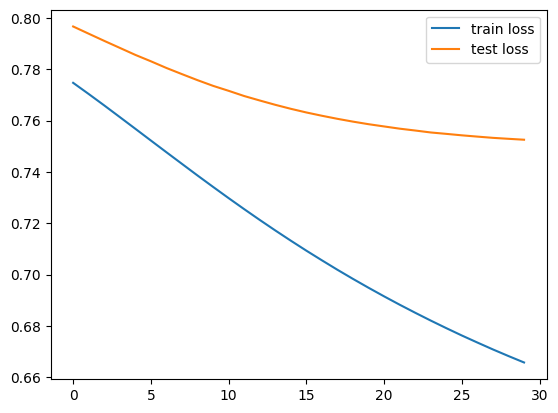

In [37]:
# plot losses
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="test loss")
plt.legend()
plt.show()


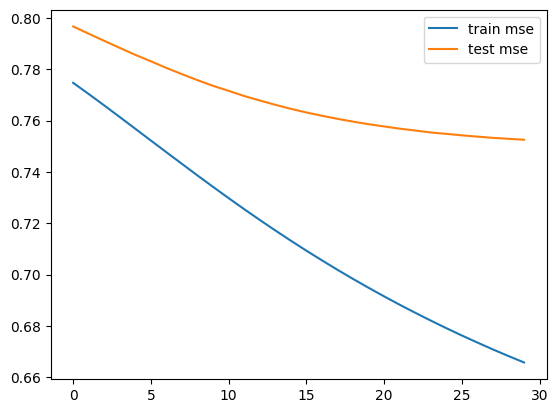

In [38]:
# plot mse
plt.plot(history.history['mse'], label="train mse")
plt.plot(history.history['val_mse'], label="test mse")
plt.legend()
plt.show()

In [41]:
model.save('MF_model.h5') 

with open('mu.pkl', 'wb') as f:
    pickle.dump(mu, f)

# single prediction 

In [45]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError

In [46]:
model = load_model('MF_model.h5', custom_objects={'mse': MeanSquaredError()})

with open('mu.pkl', 'rb') as f:
  mu = pickle.load(f)

In [51]:
def predict_single_rating(model, user_id, movie_id, mu):
    """
    Function to predict the rating for a specific user and movie.
    
    Parameters:
    - model: Trained Keras model
    - user_id: ID of the user (int)
    - movie_id: ID of the movie (int)
    - mu: Global mean rating (float)
    
    Returns:
    - final_predicted_rating: Predicted rating (float)
    """
    # Prepare inputs for the model (as arrays)
    user_input = np.array([user_id])  # Shape should be (1,)
    movie_input = np.array([movie_id])  # Shape should be (1,)

    # Predict the rating deviation from the mean
    predicted_rating = model.predict([user_input, movie_input])

    # Add the global mean rating back to the prediction
    final_predicted_rating = predicted_rating[0][0] + mu

    return final_predicted_rating

In [73]:
def existence(user_id , movie_id):
    rate=df[(df.User == user_id) & (df.movie_idx == movie_id)].Rating.values
    if len(rate)!=0:
            print(f"{(user_id, movie_id)} exists in the data with value : {rate[0]} ")
    else:
            print(f"{(user_id, movie_id)} does not exist in the data ")

In [74]:
print(predict_single_rating(model, 799, 100, mu))
existence(799, 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3.436414852816428
(799, 100) does not exist in the data 


In [77]:
print(predict_single_rating(model, 3891, 890, mu))
existence(3891, 890)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4.182428106743659
(3891, 890) exists in the data with value : 4 


In [78]:
print(predict_single_rating(model, 203, 3256, mu))
existence(203, 3256)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3.285359457213248
(203, 3256) exists in the data with value : 3 
